In [1]:
import pandas as pd
import json
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
import string

In [2]:
user_demo_profiles_path = './data/User demo profiles.json'
labeled_tweets_path = './data/Twitter_User_Handles_labeled_tweets.json'
labeled_users = './data/labeled_users.csv'

df_tweets = pd.read_json(labeled_tweets_path, orient='index')
df_profiles = pd.read_json(user_demo_profiles_path, orient='values')

In [3]:
df_profiles

,id,name,screen_name,description,lang,img_path
0,12488,Chad Boyce,djsnipa1,"Multimedia Developer, Graphic Designer, DJ, an...",NA,profile pics/60147.jpeg
1,719703,Tomato 😷,Tomato,🇭🇰Rise Up!,NA,profile pics/60148.jpeg
2,722153,blank,blank,"Someone who thinks too much, acts too little.",NA,profile pics/60149.jpeg
3,749003,A ring made from a spoon --- E83.31,IYQbd,Has the kind of luck that turns a professional...,NA,profile pics/60150.jpeg
4,1896301728,عبدالله,755531,,NA,profile pics/60151.jpeg
...,...,...,...,...,...,...
3604,4895390642,Dalton's Eyeliner,FlyAwayEyeliner,"I'm Dalton's eyeliner, who are you? Are you Da...",NA,profile pics/64267.jpeg
3605,4895831833,Jamie Loftus,cowboyjamie77,"41 year old male. interests include learning, ...",NA,profile pics/64268.jpeg
3606,4921995243,saved,memelady,,NA,profile pics/64269.jpeg
3607,4924158634,Winter da CoffeeCat,WinterStar21,"Big fan of cats, coffee, horror stuff and anim...",NA,profile pics/64270.jpeg


In [4]:
df_tweets.index.name = 'user_id'

In [5]:
df_tweets

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12488,"YKAR, a futuristic sans serif font by @Emmeran...",@MBonvoyAssist Who can I contact about the ver...,@SSlnes I’d like to win!,@LuckyDucksNFT @Rydog,Now I'm heading to B1000th Floor! #quickrogue,Check this out! https://t.co/eOtMJ99jE7,@AskLyft Thank you! Yes I'm doing it now,@AskLyft Please help me! I got scammed and nee...,@catalogscanner #AnimalCrossing #ACNH #Nintend...,@catalogscanner #AnimalCrossing #ACNH #Nintend...,...,@BandaruOrganics Hello! Will you get these in ...,Evernote helps me remember everything. Get it ...,FINAL FANTASY ALL THE BRAVEST is here! An easy...,My MIR1 flying from San Francisco to Phoenix i...,@MikeRogers0 I love LivePage! Thank you so muc...,I just signed up for @CopyApp and got 5 GB fre...,Say hello to the future of e-mail at http://t....,Check out my personalized 2012 Gaming Summary ...,Mark Bale feat. Cosmo Klein - Gimme Some Love ...,Matty Menck - Rain (Original Mix) http://t.co/...
719703,"In other words, it’s good news about the vacci...",People forget that Trump didn’t even want to s...,The Taiwan government’s response to COVID is s...,#ACNH https://t.co/cEUo84rfvV,Quite happy with yesterday's work on my zen ga...,"Yikes. It isn’t easy to comprehend, as with al...",It’s harder and harder to get excited about bu...,Excellent news. I’ve been feeling so exhausted...,What a line. https://t.co/CnWN9lx4uS,"As a HKer, I’ve gotten used to disappointments...",...,This #iPhone6′s vibration is weak. I got a cal...,@stewart Young people in Hong Kong (myself inc...,Now I really have to go to New York in the nex...,"Wow, congrats @StephenAtHome. Very mixed feeli...",Glitch was a wonderful game and I really miss ...,I was in the game until the final few minutes....,"So, bringing my MacBook, I went to the hotel l...",But the flight was majorly delayed! Thank God ...,I was going to miss the last hours of the game...,Tonight I'm getting pretty emotional when I th...
749003,would it be fair to call lil nas x the first s...,@BillyKumo He did,Decided to only engage with Batman and Batman ...,I'm reading a 1953 Mad magazine Batman parody ...,"Happy Batman Day, Batman people!\nBatman!",Because it's not constrained by the suits the ...,In the second half Robbie declares that his ca...,iffy https://t.co/GnfMHs3h06,I forgot the second wink which makes the first...,"Spike hires a campaign manager, Olio Slick (😉)...",...,ha canadian mathen. i get it https://t.co/crx2...,@madmup https://t.co/XvnNzVcw5v,This whole run feels like it wants to be that ...,This page layout makes no sense to me.\n\nI wa...,There are 911 stans https://t.co/BnRXVrsbb6,"I triggered the ""do you really want to tweet t...",@MnDPS_DPS @MnDPS_MSP Get f.ucked,This is dystopic https://t.co/QreOku3Zit,This is neat. The motion lines show the monste...,Love\nAngel\nMovie\nBaby https://t.co/L2efpaqKrh
822540,@Asmongold ❤️ 🙏,@Hunter4J @Wario64 bonk,@FF_XIV_EN #FFXIV400kSweepstakes,@DaysUntilEW Nice,@AndrewMFanco @jdflynn Ed McBoy,@Wario64 OOS. getting real tired of GameStop t...,"@Wario64 XSX is sold out, was removed from car...","@Wario64 I have pro, can't add to cart",@pixelpipes @dark1x Wish they had used that al...,@WBNG12News RIP Squishy ♥️,...,@kazoodac @Wario64 Stacking 20% off with $10 c...,@Patriotssuck19 @NYRangers lol,@nealmchale @RickCarpiniello Tarasenko or Jade...,@RickCarpiniello The tradition of Festivus beg...,"@Wario64 Glad I spotted this, finally opened m...","@RickCarpiniello You too, Carp.",@MoadhtheGreat @Wario64 I was shocked at how n...,@Wario64 I remember when Newegg was known for ...,@djdresden Yub Nub,@BinghamtonNow What happened to staying 6 feet...
865071,@robo_james How about pizza dipped in water 🤦🏻‍♂️,Day 21 of Quarantine: We installed a trapeze i...,"I love Portuguese egg tarts too, but is this r...","Well, that was an unexpected memory from the r...","The #GDPR has many benefits, but needing to co...",Why does nobody talk about the f

In [6]:
df_users = pd.read_csv(labeled_users)

In [7]:
df_users.head()

,user_id,is_female,year_born,race
0,12488.0,0.0,1980.0,4.0
1,719703.0,0.0,1985.0,4.0
2,722153.0,1.0,1973.0,3.0
3,749003.0,0.0,1982.0,5.0
4,755531.0,0.0,1982.0,4.0


### Preprocssing Text
- all lowercase
- remove urls
- remove @user
- remove #hashtag
- remove punctuations 
- split dataset to train and validation

In [8]:
# A function to preprocessing a column of tweets, the input should be df_tweets['i'], i = 0,...,99
def cleaned_tweet(tweets):
    #lower case
    tweets = tweets.str.lower()
    #remove urls
    tweets = tweets.apply(lambda x: re.sub(r'https?:\/\/\S+', '', str(x)))
    # remove url/website that didn't use http, is only checking for .com websites 
    # so words that are seperated by a . are not removed
    tweets = tweets.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    # remove @user
    tweets = tweets.apply(lambda x: re.sub(r'@[A-Za-z0-9_]+', '', x))
    # remove #hashtag
    tweets = tweets.apply(lambda x: re.sub(r'#[A-Za-z0-9_]+', '', x))
    # remove special characters, punctuations
    tweets = tweets.apply(lambda x: re.sub(r'\W+', ' ', x))
    # remove short words length less than 3
    tweets = tweets.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # remove Re-Tweet
    tweets = tweets.apply(lambda x: re.sub(r'^RT[\s]+', '', x))
    # remove numbers
    tweets = tweets.apply(lambda x: re.sub(r'\d+', '', x))
    return tweets

In [9]:
for col in df_tweets.columns:
    df_tweets[col] = cleaned_tweet(df_tweets[col])
df_tweets

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12488,ykar futuristic sans serif font,who can contact about the very rude and poor s...,like win,,now heading bth floor,check this out,thank you yes doing now,please help got scammed and need help finding ...,,,...,hello will you get these g please sono wood tr...,evernote helps remember everything get now for...,final fantasy all the bravest here easy play a...,mir flying from san francisco phoenix pocket p...,love livepage thank you much for developing re...,just signed for and got free online storage,say hello the future mail follow for hot news ...,check out personalized gaming summary from an...,mark bale feat cosmo klein gimme some love ori...,matty menck rain original mix
719703,other words good news about the vaccine safety...,people forget that trump didn even want sign t...,the taiwan government response covid simply ou...,,quite happy with yesterday work zen garden jus...,yikes isn easy comprehend with all speeches fr...,harder and harder get excited about buying new...,excellent news been feeling exhausted this out...,what line,hker gotten used disappointments like this fro...,...,this vibration weak got call while pants pocke...,young people hong kong myself included will no...,now really have new york the next months and a...,wow congrats very mixed feelings right now goi...,glitch was wonderful game and really miss stil...,was the game until the final few minutes could...,bringing macbook went the hotel lobby use thei...,but the flight was majorly delayed thank god f...,was going miss the last hours the game because...,tonight getting pretty emotional when think ab...
749003,would fair call lil nas the first successful o...,did,decided only engage with batman and batman adj...,reading mad magazine batman parody harvey kur...,happy batman day batman people batman,because not constrained the suits the furnitur...,the second half robbie declares that his campa...,iffy,forgot the second wink which makes the first w...,spike hires campaign manager olio slick his op...,...,canadian mathen get,,this whole run feels like wants that hawkeye r...,this page layout makes sense want read green f...,there are stans,triggered the you really want tweet that proba...,get ucked,this dystopic,this neat the motion lines show the monster fa...,love angel movie baby
822540,,bonk,,nice,mcboy,oos getting real tired gamestop today,xsx sold out was removed from cart after multi...,have pro can add cart,wish they had used that album art for quite op...,rip squishy,...,stacking off with credits for high profile rel...,lol,tarasenko jaden schwartz would have been nice ...,the tradition festivus begins with the airing ...,glad spotted this finally opened sealed copy a...,you too carp,was shocked how not fun the first hours this g...,remember when newegg was known for their great...,yub nub,what happened staying feet apart from other pe...
865071,how about pizza dipped water,day quarantine installed trapeze the living ro...,love portuguese egg tarts too but this really ...,well that was unexpected memory from the raver...,the has many benefits but needing constantly a...,why does nobody talk about the fact that donke...,basically put the info one needs steal identit...,the start,the start village and ready run the fort wadsw...,,...,,cheering the swiss the williamsburg,translation the password you chose too difficu...,alicia busts open our shipping container carls...,who that,wow sabía tampoco que había estado coma por cu...,did leave prison review app running again,just passed sing sing the train heading north ...,omigod omigod omigod,yvr jfk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323699762,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3352812676,women guide burn fat and build muscle the holy...,wondering what now that the weather turning co...,the what who

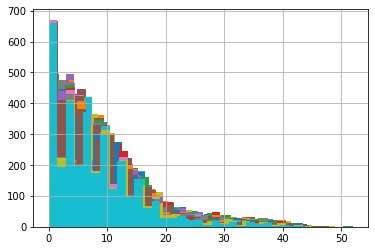

In [10]:
for j in range(100):
    seq_len = [len(i.split()) for i in df_tweets[j]]
    pd.Series(seq_len).hist(bins = 30)

In [11]:
# Combine the race and age label to the preprocessed tweets
df_cleanedtweets = pd.merge(df_tweets, df_users, on="user_id")
df_cleanedtweets.columns

Index([  'user_id',           0,           1,           2,           3,
                 4,           5,           6,           7,           8,
       ...
                93,          94,          95,          96,          97,
                98,          99, 'is_female', 'year_born',      'race'],
      dtype='object', length=104)

In [12]:
df_cleanedtweets.to_csv('./data/preprocessed_race_tweets.csv')

In [36]:
#### Concaternate 0-99 text column into one
import pandas as pd

race_df = pd.read_csv('./data/preprocessed_race_tweets.csv')

race_dict = {}
race_dict['text'] = race_df['0'].to_list()
race_dict['label'] = race_df['race'].to_list() * 100
race_dict['user_id'] = race_df['user_id'].to_list() * 100

for col in range(1, 100):
    race_dict['text'] += race_df[str(col)].to_list()
    
race_df = pd.DataFrame.from_dict(race_dict)

In [37]:
## drop nan 
import re
import numpy as np

race_df.dropna(subset=['text'], inplace=True)

str_ls = []
for s in race_df['text']:
    temp = re.sub('None', '', s)
    str_ls.append(temp)
    
race_df['text'] = str_ls

race_df['text'] = race_df['text'].replace(r'^\s*$', np.NaN, regex=True)

print(race_df['text'].isna().sum())

race_df.dropna(subset=['text'], inplace=True)
len(race_df)

14145


289119

In [38]:
race_df['label'].value_counts()

4.0    224287
1.0     26269
2.0     16292
5.0     10365
3.0      9189
Name: label, dtype: int64

In [41]:
race_df.loc[:, 'label'] = np.where(
   (race_df['label'] == 5), np.nan, race_df['label']
   )

race_df.dropna(inplace=True)
len(race_df)

276037

In [42]:
race_df.to_csv("./data/preprocessed_race_tweets.csv")

#### Merge all 100 tweets into one column

In [13]:
df_cleanedtweets['all_tweets'] = df_cleanedtweets[[i for i in range(100)]].agg(' '.join, axis=1)

In [14]:
df_cleanedtweets['all_tweets']

0       ykar futuristic sans serif font who can contac...
1       other words good news about the vaccine safety...
2       would fair call lil nas the first successful o...
3        bonk  nice mcboy oos getting real tired games...
4       how about pizza dipped water day quarantine in...
                              ...                        
3271     None None None None None None None None None ...
3272    women guide burn fat and build muscle the holy...
3273    even though school cancelled and grades don ma...
3274    and what are you drunk hillary supporter women...
3275    married    husbands ios android brasspistol ev...
Name: all_tweets, Length: 3276, dtype: object

In [15]:
assert len(df_cleanedtweets[0]) == len(df_cleanedtweets['all_tweets'])

#### remove None in `all_tweets`

In [16]:
import re

str_ls = []
for s in df_cleanedtweets['all_tweets']:
    temp = re.sub('None', '', s)
    str_ls.append(temp)
    
df_cleanedtweets['all_tweets'] = str_ls

In [17]:
df_cleanedtweets['all_tweets']

0       ykar futuristic sans serif font who can contac...
1       other words good news about the vaccine safety...
2       would fair call lil nas the first successful o...
3        bonk  nice mcboy oos getting real tired games...
4       how about pizza dipped water day quarantine in...
                              ...                        
3271                                                  ...
3272    women guide burn fat and build muscle the holy...
3273    even though school cancelled and grades don ma...
3274    and what are you drunk hillary supporter women...
3275    married    husbands ios android brasspistol ev...
Name: all_tweets, Length: 3276, dtype: object

Noted that 3271 is empty string, so remove empty string after clean "None" in `all_tweets` column

In [18]:
import numpy as np

df_cleanedtweets['all_tweets'] = df_cleanedtweets['all_tweets'].replace(r'^\s*$', np.NaN, regex=True)
df_cleanedtweets['all_tweets']

0       ykar futuristic sans serif font who can contac...
1       other words good news about the vaccine safety...
2       would fair call lil nas the first successful o...
3        bonk  nice mcboy oos getting real tired games...
4       how about pizza dipped water day quarantine in...
                              ...                        
3271                                                  NaN
3272    women guide burn fat and build muscle the holy...
3273    even though school cancelled and grades don ma...
3274    and what are you drunk hillary supporter women...
3275    married    husbands ios android brasspistol ev...
Name: all_tweets, Length: 3276, dtype: object

In [19]:
df_cleanedtweets['all_tweets'].isna().sum()

5

In [20]:
df_cleanedtweets.dropna(subset=['all_tweets'], inplace=True)

In [21]:
col = ['user_id', 'all_tweets', 'is_female', 'year_born', 'race']

In [22]:
df_cleanedtweets = df_cleanedtweets[col]

In [23]:
df_cleanedtweets

,user_id,all_tweets,is_female,year_born,race
0,12488,ykar futuristic sans serif font who can contac...,0.0,1980.0,4.0
1,719703,other words good news about the vaccine safety...,0.0,1985.0,4.0
2,749003,would fair call lil nas the first successful o...,0.0,1982.0,5.0
3,822540,bonk nice mcboy oos getting real tired games...,0.0,1979.0,4.0
4,865071,how about pizza dipped water day quarantine in...,0.0,1995.0,4.0
...,...,...,...,...,...
3270,3196361888,back someone called hungry who back watch sock...,1.0,1995.0,1.0
3272,3352812676,women guide burn fat and build muscle the holy...,1.0,1973.0,4.0
3273,3924536853,even though school cancelled and grades don ma...,1.0,1993.0,4.0
3274,4281628276,and what are you drunk hillary supporter women...,0.0,1987.0,4.0


In [24]:
df_cleanedtweets.to_csv('./data/preprocessed_tweets_with_race&age.csv')

## Preprocessing text for age data

In [26]:
age_tweet_path = './data/labeled_users_1145/tweets.json'
df_tweets = pd.read_json(age_tweet_path, orient='index')


In [27]:
df_tweets.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
_____zac_____,@AdvoBarryRoux @GetVidBot,"The owner of drip doesn't even have 100 mill, ...",even Lekau the owner of Drip was saying that i...,"@casspernyovest is cappin that ""R100m"" figure...",I want a recipe from @JBscotchSA for #JBLemona...,@AdvoBarryRoux Am I the only broke guy who has...,😆 https://t.co/qzxrsyCCVZ,@joearrangement Gerara here,@enhlembali @RealBlackCoffee ncoah 😊😊☺😊😂🤣😅🤣😂 h...,@enhlembali @RealBlackCoffee ncoah ☺😊 🤣😂😅🤣😂...,...,None,None,None,None,None,None,None,None,None,None
___aleia,I haven’t talked to this girl since my sophomo...,I PUT MY FUCKING TAMPONS ON THE COUNTER AT DG ...,it wouldn’t charge &gt;:( https://t.co/3h8ebQdHav,I’ve had so many embarrassing things happen to...,I went to take a super embarrassing selfie in ...,"Anyways, you’re a twink. I’m gonna go smoke so...","@AidaenGee My Venus sign is in Sag, and my ste...",https://t.co/2xBGorDpYe https://t.co/awqWMGJKKw,@trashrangoon I love you so much Morgie 🥺❤️,@mirandwar_ you’re welcome 🥺❤️❤️❤️,...,I honestly have no regrets. Like everything ha...,yeah getting your heart broke sucks but have y...,I don’t even get sad anymore I just get fuckin...,"I might look like I care, but only on camera",having all these hoes in my phone is cool but ...,I WOKE UP TO TITTY PICTURES BOYS LETS GOOOOO,changing his name in my phone and unpinning hi...,That’s not very pog of you,I got hoes in different area codes,bro you look like you pee in your bath water
___Dals,It come wit it 😭 https://t.co/ENyEtlphtP,@naomisos Thanks bby🥰😘,I’m so pretty like &lt;3 https://t.co/EY5cjNtdeI,oo u kno u nasty 😋,https://t.co/6ZEALkW4Du https://t.co/JSojWWke5f,U make my earthquake 🥺,My Gemini sun &amp; virgo rising is the reason...,Im paying all my tickets &amp; never looking back,@appleesauuce Ya’ll still there? I’m bout to c...,I value &amp; respect my babygirl so much ain’...,...,people are so typical.,😂😂 https://t.co/OpWeZIVllK,u aint gotta tell me I know the difference,I fear 😭 https://t.co/UxmXObIBk6,my daughter really got my whole personality 😭,Mfs really turn fed smh,gimme dat sweet dat nasty dat gushy stuff,"if I see her I might shoot the bitch, I should...",Lmao 😭 https://t.co/s4fPvoKVJi,Put my pain on my wrist
___schaeffer___,☝🏼👋🏼 https://t.co/xGJLlzLR7g,https://t.co/7NcaO1fyc5 https://t.co/mUFRngPzdj,https://t.co/bkhrNcvp6Q https://t.co/2Q0NPWNoul,@LakeShowYo 37-14-9,@mehggurl congrats sis keep workin!!,@D_JAMISON5 fs https://t.co/mJX5T6dhn2,how i’m spending my memorial day weekend! @sun...,🐐🐐🐐 @adamvinatieri https://t.co/CaJhDCrtOt,@Bijan5Robinson HYPE https://t.co/4J0Y6ilEOt,@ Culver WE MADE IT https://t.co/yGNqGuWkVc,...,@AlexEnglen @OSUMBB https://t.co/uRIDB6ij5U,goodbye father time https://t.co/cwSYLw2ANL,@AlexEnglen @OSUMBB https://t.co/nx85jQRabU,@halieallred @STEPHENincaps https://t.co/KYisp...,@halieallred @STEPHENincaps https://t.co/uycBk...,✍🏼 https://t.co/oJ1qyBwbJU,#TakeNote https://t.co/1XaFeht44y,https://t.co/xFVNPXUSzn https://t.co/siGdTbJ1rY,@megreinhardt42 😂😂😂 https://t.co/3kxWjI2YoY,@jakins215 😢 https://t.co/B0dGRkRMgs
__andresiscool,Enough https://t.co/gLarVLIHxW,Some of the worst people I’ve ever met are the...,@asilvvaa_ No bars,People that like Olivia rodrigo are the same p...,@oscarallonso Hope ur having a good one doggy 🙏🏼,People are still putting rubber bands on water...,Popeyes should close at midnight not 9:00,Where my guys at what’s the move for today,@jacobzmcclain Not worth ur time,"Worked 2 days, 20 hours, last week in this new...",...,@hugotmail1 Sup lil bro,Can’t believe I’ve never held a snake,We withering all summer 2021 let’s go https://...,If you cause car accidents you’re automaticall...,Fr I’m like can I get a mcchicken and they’re ...,More back problems for today 🙏🏼,Slim Jims have gotten waaaay worse recently,At all 😩 https://t.co/J0QEowOrHS,Self control is leaving the stiiizy at home wh...,I could fuck w/ some boba rn


In [28]:
df_tweets.index.name = 'screen_name'
df_tweets

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
screen_name,,,,,,,,,,,,,,,,,,,,,
_____zac_____,@AdvoBarryRoux @GetVidBot,"The owner of drip doesn't even have 100 mill, ...",even Lekau the owner of Drip was saying that i...,"@casspernyovest is cappin that ""R100m"" figure...",I want a recipe from @JBscotchSA for #JBLemona...,@AdvoBarryRoux Am I the only broke guy who has...,😆 https://t.co/qzxrsyCCVZ,@joearrangement Gerara here,@enhlembali @RealBlackCoffee ncoah 😊😊☺😊😂🤣😅🤣😂 h...,@enhlembali @RealBlackCoffee ncoah ☺😊 🤣😂😅🤣😂...,...,None,None,None,None,None,None,None,None,None,None
___aleia,I haven’t talked to this girl since my sophomo...,I PUT MY FUCKING TAMPONS ON THE COUNTER AT DG ...,it wouldn’t charge &gt;:( https://t.co/3h8ebQdHav,I’ve had so many embarrassing things happen to...,I went to take a super embarrassing selfie in ...,"Anyways, you’re a twink. I’m gonna go smoke so...","@AidaenGee My Venus sign is in Sag, and my ste...",https://t.co/2xBGorDpYe https://t.co/awqWMGJKKw,@trashrangoon I love you so much Morgie 🥺❤️,@mirandwar_ you’re welcome 🥺❤️❤️❤️,...,I honestly have no regrets. Like everything ha...,yeah getting your heart broke sucks but have y...,I don’t even get sad anymore I just get fuckin...,"I might look like I care, but only on camera",having all these hoes in my phone is cool but ...,I WOKE UP TO TITTY PICTURES BOYS LETS GOOOOO,changing his name in my phone and unpinning hi...,That’s not very pog of you,I got hoes in different area codes,bro you look like you pee in your bath water
___Dals,It come wit it 😭 https://t.co/ENyEtlphtP,@naomisos Thanks bby🥰😘,I’m so pretty like &lt;3 https://t.co/EY5cjNtdeI,oo u kno u nasty 😋,https://t.co/6ZEALkW4Du https://t.co/JSojWWke5f,U make my earthquake 🥺,My Gemini sun &amp; virgo rising is the reason...,Im paying all my tickets &amp; never looking back,@appleesauuce Ya’ll still there? I’m bout to c...,I value &amp; respect my babygirl so much ain’...,...,people are so typical.,😂😂 https://t.co/OpWeZIVllK,u aint gotta tell me I know the difference,I fear 😭 https://t.co/UxmXObIBk6,my daughter really got my whole personality 😭,Mfs really turn fed smh,gimme dat sweet dat nasty dat gushy stuff,"if I see her I might shoot the bitch, I should...",Lmao 😭 https://t.co/s4fPvoKVJi,Put my pain on my wrist
___schaeffer___,☝🏼👋🏼 https://t.co/xGJLlzLR7g,https://t.co/7NcaO1fyc5 https://t.co/mUFRngPzdj,https://t.co/bkhrNcvp6Q https://t.co/2Q0NPWNoul,@LakeShowYo 37-14-9,@mehggurl congrats sis keep workin!!,@D_JAMISON5 fs https://t.co/mJX5T6dhn2,how i’m spending my memorial day weekend! @sun...,🐐🐐🐐 @adamvinatieri https://t.co/CaJhDCrtOt,@Bijan5Robinson HYPE https://t.co/4J0Y6ilEOt,@ Culver WE MADE IT https://t.co/yGNqGuWkVc,...,@AlexEnglen @OSUMBB https://t.co/uRIDB6ij5U,goodbye father time https://t.co/cwSYLw2ANL,@AlexEnglen @OSUMBB https://t.co/nx85jQRabU,@halieallred @STEPHENincaps https://t.co/KYisp...,@halieallred @STEPHENincaps https://t.co/uycBk...,✍🏼 https://t.co/oJ1qyBwbJU,#TakeNote https://t.co/1XaFeht44y,https://t.co/xFVNPXUSzn https://t.co/siGdTbJ1rY,@megreinhardt42 😂😂😂 https://t.co/3kxWjI2YoY,@jakins215 😢 https://t.co/B0dGRkRMgs
__andresiscool,Enough https://t.co/gLarVLIHxW,Some of the worst people I’ve ever met are the...,@asilvvaa_ No bars,People that like Olivia rodrigo are the same p...,@oscarallonso Hope ur having a good one doggy 🙏🏼,People are still putting rubber bands on water...,Popeyes should close at midnight not 9:00,Where my guys at what’s the move for today,@jacobzmcclain Not worth ur time,"Worked 2 days, 20 hours, last week in this new...",...,@hugotmail1 Sup lil bro,Can’t believe I’ve never held a snake,We withering all summer 2021 let’s go https://...,If you cause car accidents you’re automaticall...,Fr I’m like can I get a mcchicken and they’re ...,More back problems for today 🙏🏼,Slim Jims have gotten waaaay worse recently,At all 😩 https://t.co/J0QEowOrHS,Self control is leaving the stiiizy at home wh...,I could fuck w/ some boba rn
...,...,...,...,...,...,..

In [29]:
for col in df_tweets.columns:
    df_tweets[col] = cleaned_tweet(df_tweets[col])
    
# merge all tweets into one column 
df_tweets['all_tweets'] = df_tweets[[i for i in range(100)]].agg(' '.join, axis=1)

df_tweets 

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,all_tweets
screen_name,,,,,,,,,,,,,,,,,,,,,
_____zac_____,,the owner drip doesn even have mill drip comp...,even lekau the owner drip was saying that was ...,cappin that rm figure inflated the deal ain wo...,want recipe from for you looking for change yo...,the only broke guy who has low sexual performa...,,gerara here,ncoah,ncoah,...,None,None,None,None,None,None,None,None,None,the owner drip doesn even have mill drip com...
___aleia,haven talked this girl since sophomore year an...,put fucking tampons the counter and the cashie...,wouldn charge,had many embarrassing things happen college th...,went take super embarrassing selfie the bathro...,anyways you twink gonna smoke some weed now,venus sign sag and step dad sag love you guys,,love you much morgie,you welcome,...,yeah getting your heart broke sucks but have y...,don even get sad anymore just get fucking piss...,might look like care but only camera,having all these hoes phone cool but like much...,woke titty pictures boys lets gooooo,changing his name phone and unpinning his convo,that not very pog you,got hoes different area codes,bro you look like you pee your bath water,haven talked this girl since sophomore year an...
___Dals,come wit,thanks bby,pretty like,kno nasty,,make earthquake,gemini sun amp virgo rising the reason why insane,paying all tickets amp never looking back,still there bout come,value amp respect babygirl much ain man meetin...,...,,aint gotta tell know the difference,fear,daughter really got whole personality,mfs really turn fed smh,gimme dat sweet dat nasty dat gushy stuff,see her might shoot the bitch should treated h...,lmao,put pain wrist,come wit thanks bby pretty like kno nasty mak...
___schaeffer___,,,,,congrats sis keep workin,,how spending memorial day weekend,,hype,culver made,...,goodbye father time,,,,,,,,,congrats sis keep workin how spending mem...
__andresiscool,enough,some the worst people ever met are the type th...,bars,people that like olivia rodrigo are the same p...,hope having good one doggy,people are still putting rubber bands watermel...,popeyes should close midnight not,where guys what the move for today,not worth time,worked days hours last week this new job posit...,...,can believe never held snake,withering all summer let,you cause car accidents you automatically smal...,like can get mcchicken and they like will that...,more back problems for today,slim jims have gotten waaaay worse recently,all,self control leaving the stiiizy home while work,could fuck some boba,enough some the worst people ever met are the ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZoeCalamaco,one person followed automatically checked,miss boyfriend,could never just housewife spent one day home ...,never get sick why does immune system choose s...,air wish was joking,love the sound rain hitting window,love you but,,people followed automatically checked,,...,people followed and one person unfollowed auto...,,still sad that shit wasn pink,feel like take the cutest selfies when sleep d...,wanna watch the pink moon friends,wish wasn insecure little biotch,there competition bby,have problems and having sugar daddy would sol...,sister made such good first impression friends,one person followed automatically checked miss...
ZoPeachy,good morning say back,happy friday send put bigger smile than this f...,cashapp zopeachy google pay amp giftrocket zob...,take peek,cashapp zopeachy google pay amp giftrocket zob...,juicy like berry,,refund for dinner put smile face like this cas...,need raise funds asap for rent please support ...,def could use pizza today,...,None,None,None,None,None,None,None,None,None,good morning say back happy friday send put bi...
ZTheBest33,,uhhhhhhhhh lmao,this cannot real lol,who put this man fatbooth lol,this the team that will win chip,wasn touched lol,england italy the euros equivalent suns bucks imo,moved from sterling dive italy who

In [32]:
df_user2 = pd.read_csv('./data/labeled_users_1145/labeled_users.csv', lineterminator='\n')
df_user2.set_index('screen_name', drop = False)

,Unnamed: 0,Unnamed: 0.1,screen_name,user_id,lang,name,location,description,protected,followers_count,...,profile_background_url,profile_image_url,user.name,num.tweets.used.Lexicon.prediction,Lexicon.age.prediction,Lexicon.gender.prediction..index.,lexicon.gender.prediction,human.labeled.gender,human.labeled.age,age
screen_name,,,,,,,,,,,,,,,,,,,,,
_____zac_____,0,1,_____zac_____,4.614412e+08,en,zac ¢,"Maryland, USA",_____Û___È_Ü´Ù,False,208,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1226134911...,@_____zac_____,100.0,27.652434,-1.457167,M,NaN,23.0,1.0
___aleia,1,2,___aleia,7.650000e+17,en,_æ___ dad ___æ_,"Ohio, USA",BLACK. LIVES. MATTER.,False,466,...,NaN,http://pbs.twimg.com/profile_images/1271280679...,@___aleia,100.0,24.111464,0.985713,F,NaN,19.0,0.0
___schaeffer___,3,4,___schaeffer___,1.257110e+09,en,Brenden Schaeffer,The Lou,Culver-Stockton College '20 ¢ Ô_Ô_Ô KM 1548...,False,811,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1268044218...,@___schaeffer___,59.0,35.518352,-3.591586,M,NaN,22.0,0.0
__drewc,8,9,__drewc,1.050000e+18,en,drew,"New York, USA",_öÂ_öé _öÂ_ö_ _ç´Ù È \r\r26 #NewYork,False,27,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1090809548...,@__drewc,134.0,24.910635,1.969121,F,NaN,26.0,1.0
__EmilyRice__,9,10,__EmilyRice__,3.797155e+09,en,em,"Marble Falls, TX",#TXST22,False,158,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8415201103...,@__EmilyRice__,100.0,25.191925,2.382856,F,NaN,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zmeadows_18,3268,3269,zmeadows_18,7.050000e+17,und,Z Meadows,"Circleville, OH",|OUCÈ23__|,False,556,...,NaN,http://pbs.twimg.com/profile_images/1252321514...,@zmeadows_18,100.0,32.385038,-1.729790,M,NaN,19.0,0.0
ZoeBerrier,3271,3272,ZoeBerrier,9.020000e+17,en,Zoâ _êâ,"Millersville, PA",MU 2021 (she/her)\r\rQueen of putting lipstick...,False,94,...,NaN,http://pbs.twimg.com/profile_images/1241199033...,@ZoeBerrier,100.0,22.585143,1.243141,F,F,20.0,0.0
ZoeCalamaco,3272,3273,ZoeCalamaco,3.214954e+09,no,Zoe _,San Angelo tx/ aspermont tx,Angelo state,False,475,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1277399838...,@ZoeCalamaco,100.0,21.348766,1.939069,F,F,21.0,0.0


In [33]:
merge_df = pd.merge(df_tweets, df_user2, on='screen_name')

In [34]:
merge_df['human.labeled.age'] = merge_df['human.labeled.age'].apply(lambda x: 1 if x >= 21 else 0)

In [35]:
# merge_df.to_csv("./data/preprocessed_tweets_with_for_age_pred.csv")

In [44]:
age_df = pd.read_csv('./data/preprocessed_tweets_with_for_age_pred.csv', lineterminator='\n')

age_dict = {}
age_dict['text'] = age_df['0'].to_list()
age_dict['label'] = age_df['human.labeled.age'].to_list() * 100
age_dict['screen_name'] = age_df['screen_name'].to_list() * 100

for col in range(1, 100):
    age_dict['text'] += age_df[str(col)].to_list()

age_df = pd.DataFrame.from_dict(age_dict)

In [45]:
age_df.dropna(subset=['text'], inplace=True)
str_ls = []
for s in age_df['text']:
    temp = re.sub('None', '', s)
    str_ls.append(temp)
    
age_df['text'] = str_ls

age_df['text'] = age_df['text'].replace(r'^\s*$', np.NaN, regex=True)

age_df['text'].isna().sum()
age_df.dropna(subset=['text'], inplace=True)
print(age_df['label'].value_counts())

age_df.to_csv('./data/preprocessed_tweets_with_for_age_pred.csv')

1    60674
0    36115
Name: label, dtype: int64
